# Prototype Version 3
This code will read data from an tsv file, this file contains associations of the name of a tandem spectra and their corresponding amino acids sequence. I will find the corresponding spectra in an mzML file. This code will then <b>visualize</b> spectra and <b>identify</b> the peaks. Based on the distances between the peaks (which are assumed to be y-ions) the code will <b>recognize</b> amino acids that could fit in between these peaks. These puzzle pieces are given a confidence score referring to their likelyhood of being part of the full peptide.
<br>
 finally a code will combine these puzzle pieces into the most likely amino acids sequence and present in in a human readable way.
<br>
this will be done using the <b>DeNovo </b> approach presented by Nick Webb (https://www.weddslist.com/ms/tandem.html)

I will investigate how well my programs predict the amino acid sequence by comparing the actual vs predicted sequence.

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the annotated spectrum.

In [1]:
import ast

# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# to read mzML files
from pyteomics import mzml

# to visualize mzML
from pyteomics import pylab_aux as pa, usi

# to find peaks
from scipy.signal import find_peaks
from peakutils import indexes

## reading the files

In [2]:
# file that contains the associations between tandem spectra name and amino acids sequence
df = pd.read_csv("../data/psm_a.tsv", sep="\t")

In [3]:
df.head()

,Spectrum,Spectrum File,Peptide,Modified Peptide,Extended Peptide,Prev AA,Next AA,Peptide Length,Charge,Retention,...,Protein Description,Mapped Genes,Mapped Proteins,Parent Scan Number,Apex Retention Time,Apex Scan Number,Retention Time Start,Retention Time End,Retention Time FWHM,Traced Scans
0,2015-05-19_MRC5_a.05045.05045.4,interact.pep.xml,VHGPGIQSGTTNKPNK,NaN,GCDPSRVR.VHGPGIQSGTTNKPNK.FTVETRGA,R,F,16,4,833.6553,...,Filamin-A,NaN,NaN,5044,837.50806,5075,820.00700,860.02106,14.907001,66
1,2015-05-19_MRC5_a.05137.05137.3,interact.pep.xml,YHTVNGHNCEVR,YHTVNGHNCEVR,VDKIVIQK.YHTVNGHNCEVR.KALSKQEM,K,K,12,3,848.0802,...,Heterogeneous nuclear ribonucleoprotein A1,HNRNPA1L3,sp|A0A2R8Y4L2|RA1L3_HUMAN,5134,0.00000,0,0.00000,0.00000,0.000000,0
2,2015-05-19_MRC5_a.05268.05268.3,interact.pep.xml,NQTAEKEEFEHQQK,NaN,EIINWLDK.NQTAEKEEFEHQQK.ELEKVCNP,K,E,14,3,867.4215,...,Heat shock cognate 71 kDa protein,NaN,NaN,5267,855.37700,5188,834.13904,922.82404,20.950000,133
3,2015-05-19_MRC5_a.05273.05273.3,interact.pep.xml,RDHALLEEQSK,NaN,KVQQLVPK.RDHALLEEQSK.QQSNEHLR,K,Q,11,3,868.4587,...,Alpha-actinin-4,NaN,NaN,5272,873.95000,5310,860.02106,902.49304,17.305000,63
4,2015-05-19_MRC5_a.05307.05307.3,interact.pep.xml,IECDDKGDGSCDVR,IECDDKGDGSCDVR,VEGPSQAK.IECDDKGDGSCDVR.YWPQEAGE,K,Y,14,3,873.5540,...,Filamin-A,FLNC,sp|Q14315|FLNC_HUMAN,5306,860.02106,5221,830.17100,912.24900,16.953001,118


In [4]:
# file that contains the amino acids and their weights
# TODO for now there is a distinction between "I" and "L"
# They are indistinguishable by weight so I cant really know which one it is
aa = pd.read_csv("../data/single_double_amino_acids.csv")

In [5]:
mz_path = '../data/2015-05-19_MRC5_a.mzML'

In [6]:
# this creates a dictionary of matches between the mzMl file and the psm_a.tsv
# this should only return MS/MS where we have the Peptide sequence already identified.
i = 0
matches = []
plotting_dict = None
with mzml.MzML(mz_path) as reader:
    for spectrum in reader:
        # looking for the first match between the 2 files
        for name in df["Spectrum"]:
            if name in spectrum.get('spectrum title') :
                # print(spectrum["index"], spectrum.get("spectrum title"))
                # Extract relevant information
                matches.append([spectrum,df[df["Spectrum"] == name]["Peptide"].sum(),
                               df[df["Spectrum"] == name]["Hyperscore"].sum()])
                """
                spectrum_name = name
                mz_array = spectrum['m/z array']
                intensity_array = spectrum['intensity array']
                precursor_mz = (spectrum['precursorList']['precursor']
                                [0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])

                plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
                """
        #         break
        # if plotting_dict != None:
        #     break
m_df = (pd.DataFrame(matches, columns=["Spectrum","Peptide","Hyperscore"])
    .sort_values(by = ["Hyperscore"], axis=0, ascending= False)
    .reset_index(drop=True))

# exec time 2 ~ 3 minutes

In [7]:
#m_df.to_csv("spectrum_peptide_matches.csv", index=False)

## deciding on which Peptide sequence to use
I am going to aim for the shortest one for simplicity

In [8]:
print(min(m_df["Peptide"], key = len))
print(m_df[m_df["Peptide"] == "HELIEFR"])
pep_loc = 7103

HELIEFR
                                               Spectrum  Peptide  Hyperscore
7103  {'index': 11186, 'id': 'controllerType=0 contr...  HELIEFR      22.679


In [9]:
# Peptide Sequence to find
peptide = m_df["Peptide"].iloc[pep_loc]
print("Peptide sequence:", peptide)
mz_array = m_df["Spectrum"].iloc[pep_loc]['m/z array']
intensity_array = m_df["Spectrum"].iloc[pep_loc]['intensity array']
precursor_mz = m_df["Spectrum"].iloc[pep_loc]['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']
plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}


Peptide sequence: HELIEFR


## Finding Peaks

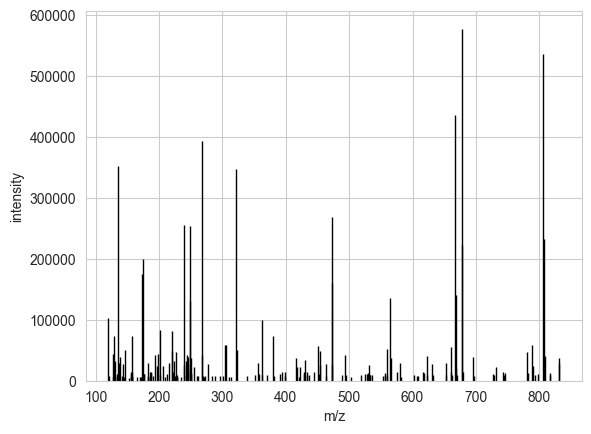

<Figure size 1200x600 with 0 Axes>

In [10]:
s1 = pd.DataFrame(plotting_dict)
pa.plot_spectrum(plotting_dict)
plt.figure(figsize=(12,6))
plt.show()

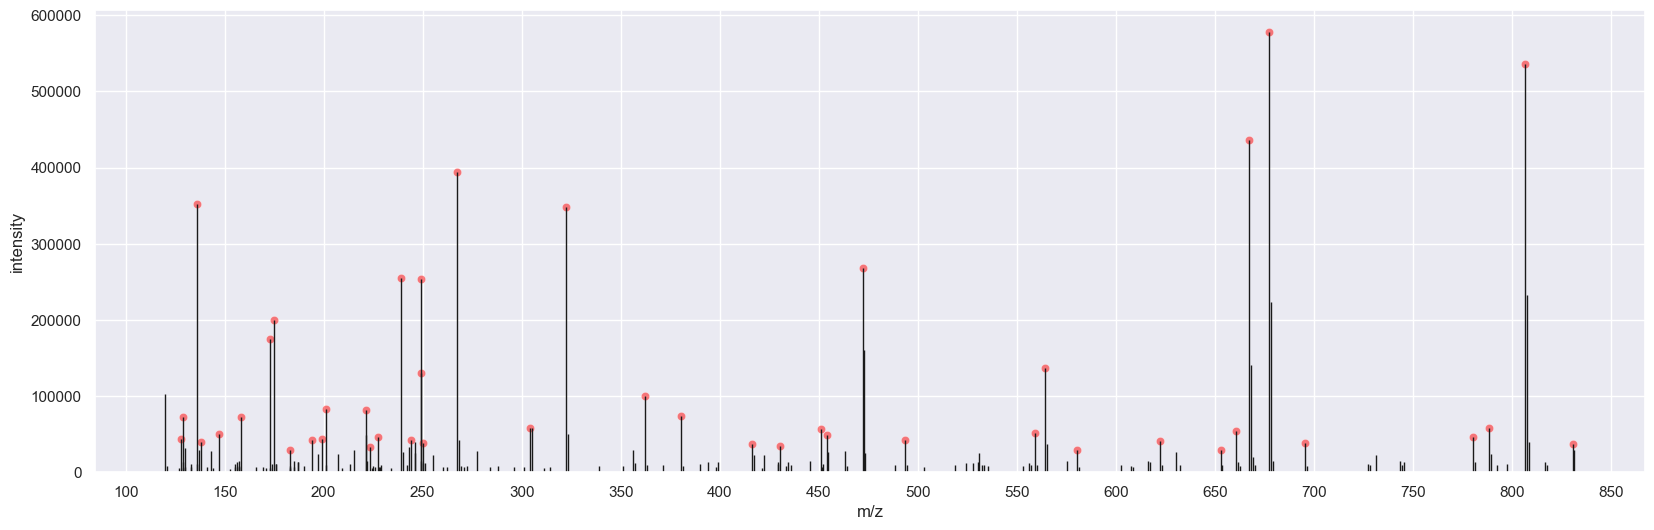

In [11]:
sp_height = intensity_array.max()*0.05
sp_dist = None
sp_prom = None
#TODO find ways to optimize for these parameters, possible based on characteristics of each spectrum
# 5% of max height should be the cutoff threshold
# i.e.: based on how long we expect the amino acid sequence to be
# what determines wheter a peak is useful, is there someway we can find out?
# 

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.set_theme(rc={'figure.figsize':(20,6)})
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5).set_xticks(np.arange(0,1200,50))
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.figure(figsize=(12,6))
plt.show()

<Axes: xlabel='m/z', ylabel='intensity'>

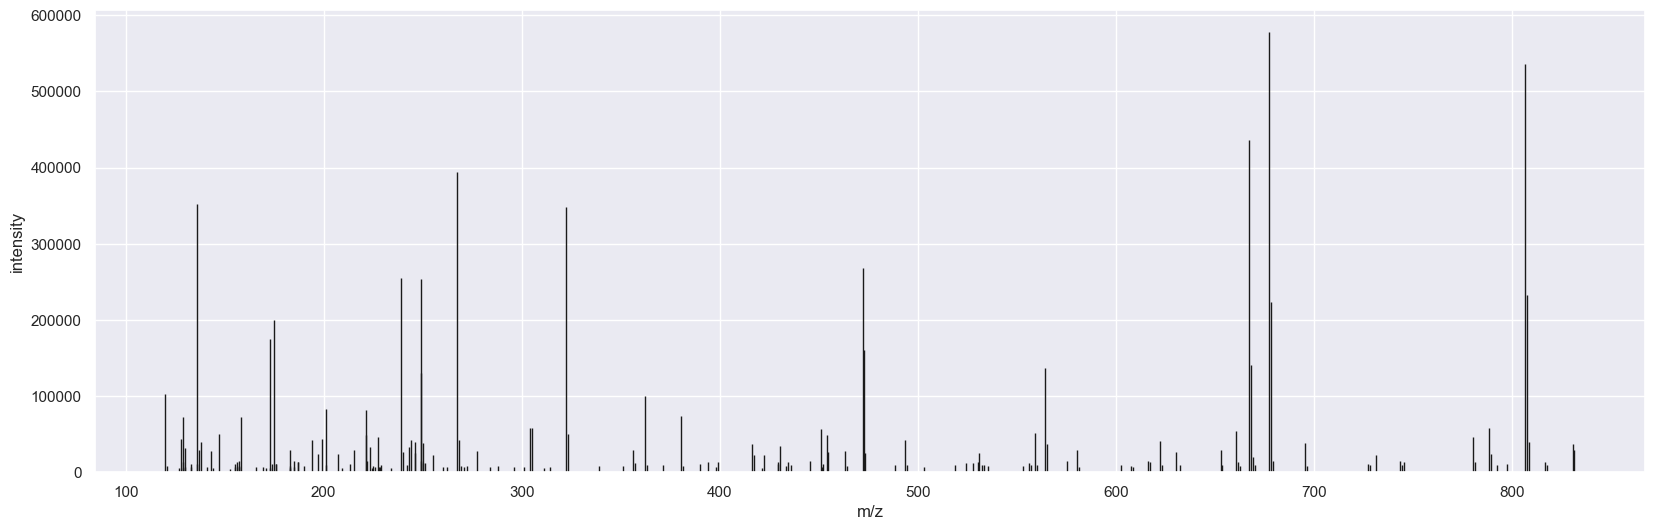

In [187]:
pa.plot_spectrum(plotting_dict)

## annotating the spectra with pyteomics

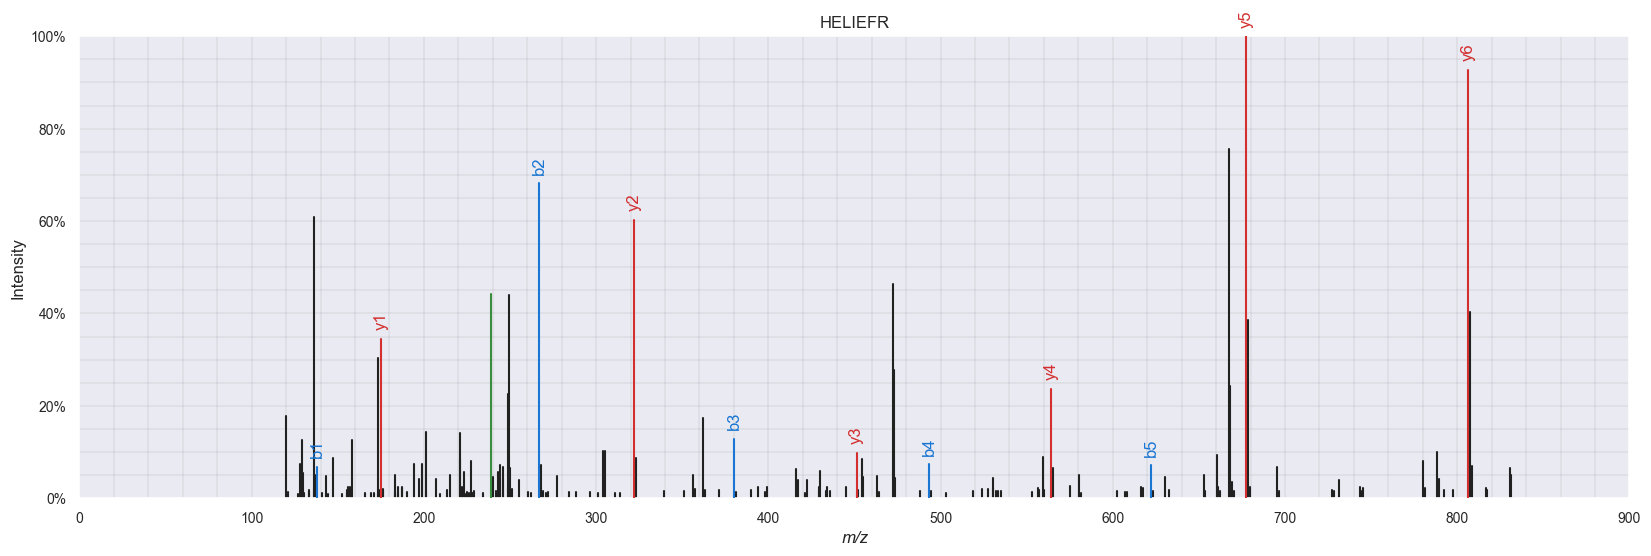

7

In [12]:
pa.annotate_spectrum(plotting_dict, peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=peptide)
#plt.figure(figsize=(12,6))
plt.show()
len(peptide)

## Functions for finding the sequence

In [13]:
# import importlib
# import other_files.my_funcs as mine
# importlib.reload(mine)
# from other_files.my_funcs import find_aa_seq

In [14]:
# normalize all the peaks to percentages
percentage_int = intensity_array/np.max(intensity_array) * 100

In [15]:
# cheesing an issue with the apply function
combo_df = aa

In [98]:
import math
def find_closest_aa(value, thres = 2.5):
    """ Find the closest amino acid to a given mass.
    this code takes a dataframe with single amino acids and combinations of amino acids in this format

        full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    using this dataframe and a given mass, it will find the closest amino acid
     or combination of 2 amino acids to the given mass.
    It will only return amino acids that are within the threshold.
    It returns a list of lists, where each list contains the letter of the amino acid, its mass and the error.
    """
    # TODO remove useless calculations from this like closeness_list having values that I never use
    if math.isnan(value) == True:
        return None
    single_df = combo_df.iloc[:,:-22]
    double_df = combo_df.set_index(["letter"]).iloc[
                :,[i for i in range(-22, -0)]]
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(single_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        if error > thres:
            loop_for_single = False
        else:
            name_idx = single_df["letter"].iloc[idx]
            closeness_list.append([name_idx, aam_array[idx], error])
            single_df = single_df.drop(single_df.index[idx])
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        error = (np.abs(double_df - value)).min().min()
        r, c = np.where(double_df == error + value)
        # if error wouldve been negative np.where will not find r, c
        # and pass empty arrays creating error
        if r.size == 0 :
            # print("boink")
            r, c = np.where(double_df == value - error)
        if error > thres:
            loop_for_combo = False
        else:
            name_idx = double_df.index[r[0]]+ "+" + double_df.columns[c[0]]
            closeness_list.append([name_idx, double_df.iloc[r[0],c[0]], error])
            double_df.iloc[r[0],c[0]] = None
    # print("closest aa is: ", name_idx, " ,with mass: ",
    # aam_array[idx], "Da. With an error of: ", error, "Da.")
    closeness_list.sort(key=lambda x: x[2])
    if closeness_list:
        # return closeness_list[0]
        return closeness_list[0][0]
    return None


'''
I would love to decided a closeness factor by iterating over the weights
and seeing how close they are to each other on average. Does this make sense?
'''

'\nI would love to decided a closeness factor by iterating over the weights\nand seeing how close they are to each other on average. Does this make sense?\n'

# Creating the distance Matrix

In [99]:
# really bad practice here, look away kids
mz_peaks = mz_array[sci_peak]
intensity_peaks = intensity_array[sci_peak]
mz_round = np.round(mz_peaks, decimals= 6)

In [100]:
# on my stackoverflow someone suggested a better way to create my distance matrix
# however I am now so deep in this going back would cost too much time

# this code builds a distance matrix for the given mz_array
# unless there is already a file in the directory it can just read

def rename(column):
    new = mz_round[int(column)]
    return new

try:
    df_aa = NONEpd.read_csv("shortest_example_matrix_named.csv").set_index("Unnamed: 0")
except:
    distance_matrix = []
    for column, i in zip(mz_round, range(len(mz_round))):
        distance_matrix.append([])
        for row in mz_round:
            distance_matrix[i].append(np.abs(row - column))

    df_dm = pd.DataFrame(distance_matrix)
    df_dm.columns = df_dm.columns.map(str)

    # for i in range(len(mz_round)):
    #     for j in range(i):
    #         df_dm.iat[i,j] = None
    for i in range(len(mz_round)):
        for j in range(len(mz_round)):
            if j >= i:
                df_dm.iat[i,j] = None
            if df_dm.iat[i,j] < 55 or df_dm.iat[i,j] > 480:
                df_dm.iat[i,j] = None

    # if j <= i:
    #     df_dm.iat[i,j] = None
    # drop columns with no values (all NaN)
    df_dm.dropna(axis = 1, how="all", inplace = True)

    print("starting mapping")
    df_aa = df_dm.map(find_closest_aa)
    print("mapping complete")

    df_aa.rename(columns=rename, inplace=True)
    df_aa.rename(index=rename, inplace=True)

    df_aa.to_csv("below_shortest_example_matrix_named.csv")

    #have to reread so dictionaries are reconverted into strings
    # this is stupid but makes the code work consistently with read csv files
    df_aa = pd.read_csv("below_shortest_example_matrix_named.csv").set_index("Unnamed: 0")


starting mapping
mapping complete


In [101]:
# df_aa.drop(columns=["Unnamed: 0"], inplace = True)

In [102]:
df_aa.columns


Index(['128.107193', '129.102585', '136.075821', '138.066132', '147.112747',
       '158.092529', '173.128571', '175.119186', '183.113251', '194.091873',
       '199.180435', '201.123505', '221.103302', '223.155685', '227.175201',
       '239.114014', '244.165649', '249.098694', '249.159683', '250.163086',
       '267.108826', '304.16095', '322.187408', '362.182098', '380.192444',
       '416.191345', '430.241272', '451.228271', '454.241638', '472.251099',
       '493.277924', '559.295715', '564.313843', '580.275269', '622.31842',
       '652.839417', '660.330444', '667.30481', '677.398987', '695.33606'],
      dtype='object')

In [103]:
import json

#print(type(df_aa[175.11891174316406].loc[120.08098602294922]))
# print(type(ast.literal_eval(df_aa["175.11891174316406"].loc[120.08098602294922])))
#print(type(ast.literal_eval(df_aa[175.11891174316406].loc[175.11891174316406])))

# np.where(mz_round == 233.09417724609375)[0][0]

In [104]:
print(df_aa.columns.values[-1])
df_aa[df_aa.columns.values[-1]]

695.33606


Unnamed: 0
128.107193    NaN
129.102585    NaN
136.075821    NaN
138.066132    NaN
147.112747    NaN
158.092529    NaN
173.128571    NaN
175.119186    NaN
183.113251    NaN
194.091873    NaN
199.180435    NaN
201.123505    NaN
221.103302    NaN
223.155685    NaN
227.175201    NaN
239.114014    NaN
244.165649    NaN
249.098694    NaN
249.159683    NaN
250.163086    NaN
267.108826    NaN
304.160950    NaN
322.187408    NaN
362.182098    NaN
380.192444    NaN
416.191345    NaN
430.241272    NaN
451.228271    NaN
454.241638    NaN
472.251099    NaN
493.277924    NaN
559.295715    NaN
564.313843    NaN
580.275269    NaN
622.318420    NaN
652.839417    NaN
660.330444    NaN
667.304810    NaN
677.398987    NaN
695.336060    NaN
780.377747      S
788.429688    NaN
806.440430      L
830.459900      H
Name: 695.33606, dtype: object

In [105]:
intensity_peaks

array([ 43303.91015625,  72864.359375  , 352007.96875   ,  39635.4375    ,
        49785.0546875 ,  73125.3828125 , 175132.046875  , 199619.421875  ,
        29268.54296875,  42716.69921875,  43118.328125  ,  83324.25      ,
        81211.265625  ,  32702.90039062,  46829.8203125 , 254876.734375  ,
        41700.22265625, 130260.3515625 , 254269.40625   ,  37984.3671875 ,
       393629.4375    ,  58498.44921875, 347909.5       ,  99764.8515625 ,
        74135.2421875 ,  36898.71875   ,  34058.296875  ,  57173.53125   ,
        48792.69921875, 267946.5625    ,  42480.1484375 ,  51676.52734375,
       136479.75      ,  29347.16601562,  40977.49609375,  29292.86328125,
        54687.328125  , 436522.3125    , 577608.625     ,  38818.734375  ,
        46561.02734375,  58399.03125   , 535404.4375    ,  37529.8203125 ])

In [106]:
print(len(intensity_peaks))
print(len(mz_round))

44
44


In [107]:
df_aa.head()

,128.107193,129.102585,136.075821,138.066132,147.112747,158.092529,173.128571,175.119186,183.113251,194.091873,...,493.277924,559.295715,564.313843,580.275269,622.31842,652.839417,660.330444,667.30481,677.398987,695.33606
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
128.107193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129.102585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136.075821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138.066132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147.112747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# print(df_aa[175.1191864013672].iloc[np.where(mz_round == mz_round[0])].values[0])
# print(df_aa.iloc[np.where(mz_round == mz_round[55])][175.1191864013672].values[0])

# aa_inf = df_aa[df_aa.columns[-1]].iloc[peak_pos]#.values[0]
# print(type(aa_inf), peak_pos)

In [180]:
def find_all_paths(n = 1000):
    # This is written to work form the highest peak down to the lowest similar to how its done by nick wedd.
    # however my distance matrix removed all points below the diagonal meaning anytime I identify a hit of an amino acid it looks like follows
    # hit a row: x and column: y. where y > x and since my program iterates over rows and then columns it sets the column to be the new row.
    # which means it starts back at the top and repeats itself in a pattern. Ill have to change the orientation of the matrix.
    full_pep_list = []

    blacklist = []

    for j in range(n):
        path_one = []
        peaks_one = []
        cur_peak = float(mz_round[-1])
        #
        while cur_peak > float(mz_round[0]):
            found = False
            for column in reversed(df_aa.columns):
                # print("conk", type(aa))
                peak_pos = np.where(mz_round == cur_peak)[0][0]
                aa_inf = df_aa[column].iloc[peak_pos]#.values[0]
                aa_int = intensity_peaks[peak_pos]
                # print("row:",mz_round[peak_pos],"column: ", column,"aa:",aa_inf,"int:",aa_int)
                #time.sleep(0.1)
                # choosing the first possible connection always as of now
                if isinstance(aa_inf, str) and peaks_one + [mz_round[peak_pos], float(column)] not in blacklist:
                    # and peaks_one not in blacklist:# or float(column) not in Xblacklist):
                    # print("\n boingoloingo \n",mz_round[peak_pos],"\n",column," \n")
                    found = True
                    # if peaks_one + [mz_round[peak_pos], float(column)] in blacklist:
                    #     found = False
                    #     print("WE HAVE BEEN DOWN THIS PATH BEFORE, ABORT MISSION AJDKSDFSDKFJ")
                    #     break
                    path_one.append(aa_inf)
                    peaks_one.append(mz_round[peak_pos])
                    #peaks_one.append(mz_round[peak_pos])
                    # ast.literal_eval is a security risk but I dont know a better way
                    # Problem is that dictionaries get saved as string when .to_csv is applied
                    cur_peak = float(column)
                    last_peak = float(column)
            if not found:
                # print("skip to next row")
                cur_peak = float(mz_round[peak_pos-1])
                found = False

        peaks_one.append(last_peak)
        blacklist.append(peaks_one)
        # info_dic = {}
        # for i in range(len(peaks_one)):
        #     info_dic[i] = peaks_one[i]
        full_pep_list.append([path_one, peaks_one])
        #print("new peptide finished")
        #print(path_one)

    #


In [181]:
find_all_paths()

In [172]:
blacklist

[[830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  194.091873,
  138.066132],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  194.091873,
  136.075821],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  183.113251,
  128.107193],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  194.091873],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  138.066132],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  136.075821],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  267.108826,
  129.102585],
 [830.4599,
  695.33606,
  622.31842,
  564.313843,
  493.277924,
  380.192444,
  322.187408,
  2

In [177]:
pd.DataFrame(full_pep_list)

,0,1
0,"[H, A, G, A, L, G, G, A, G]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
1,"[H, A, G, A, L, G, G, A, G]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
2,"[H, A, G, A, L, G, G, A, G]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
3,"[H, A, G, A, L, G, G, A]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
4,"[H, A, G, A, L, G, G, E]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
...,...,...
95,"[H, A, G, A, L, G, G, C]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
96,"[H, A, G, A, L, G, G, L]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
97,"[H, A, G, A, L, G, G, A]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."
98,"[H, A, G, A, L, G, G, S]","[830.4599, 695.33606, 622.31842, 564.313843, 4..."


In [92]:
column

830.4599

In [149]:
boobielist = [[1,2,3,4,5,6],[0]]
print([1,2,3,4,5] + [6])

[1, 2, 3, 4, 5, 6]


In [150]:
if [1,2,3,4,5] + [6] not in boobielist:
    print("b")

In [30]:
peptide

'HELIEFR'

In [ ]:
# TODO find a way to compute every single possible peptide
# this will create soooo many peptides tho
# TODO implement the DirecTag ranking methods.
# TODO is there a heuristic for this???
# like can I find a way to know ahead of time which path makes the most sense

In [183]:
"".join(full_pep_list[0][0])

'HAGALGGAG'

In [184]:
found_peptide ="".join(full_pep_list[0][0])

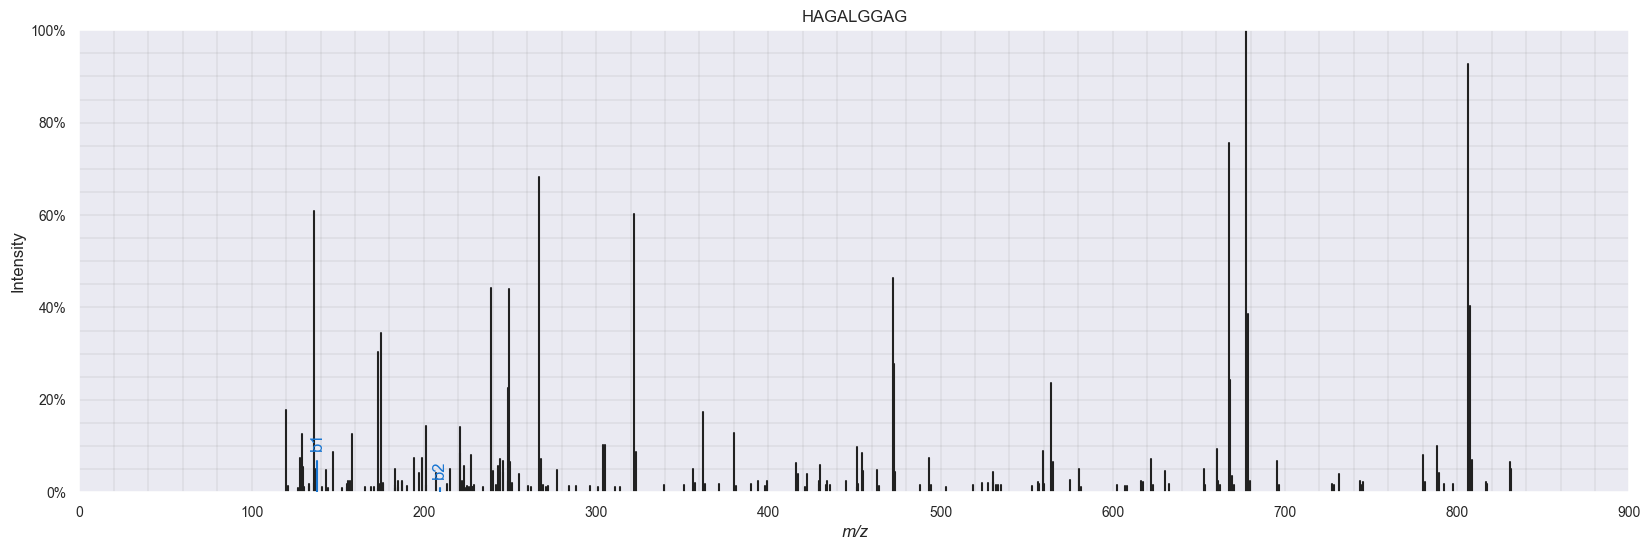

9

In [186]:
pa.annotate_spectrum(plotting_dict, found_peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=found_peptide)
#plt.figure(figsize=(12,6))
plt.show()
len(found_peptide)

In [ ]:
# original function taken from pylab_aux pyteomics

def _default_annotate_spectrum(spectrum, peptide, *args, **kwargs):

    # common kwargs
    types = kwargs.pop('ion_types', ('b', 'y'))
    aa_mass = kwargs.pop('aa_mass', mass.std_aa_mass)
    mass_data = kwargs.pop('mass_data', mass.nist_mass)
    ion_comp = kwargs.pop('ion_comp', mass.std_ion_comp)
    colors = {
        'a': '#388E3C',
        'b': '#1976D2',
        'c': '#00796B',
        'x': '#7B1FA2',
        'y': '#D32F2F',
        'z': '#F57C00',
    }
    colors.update(kwargs.pop('colors', {}))
    ftol = kwargs.pop('ftol', None)
    if ftol is None:
        rtol = kwargs.pop('rtol', 1e-5)
    text_kw = kwargs.pop('text_kw', dict(ha='center', clip_on=True, backgroundcolor='#ffffff99'))
    precursor_charge = kwargs.pop('precursor_charge', None)
    if precursor_charge is None:
        precursor_charge = _get_precursor_charge(spectrum)
    if precursor_charge is None:
        raise PyteomicsError('Could not extract precursor charge from spectrum. Please specify `precursor_charge` kwarg.')
    maxcharge = kwargs.pop('maxcharge', max(1, precursor_charge - 1))
    ax = kwargs.get('ax', None)
    # end of common kwargs

    # backend-specific kwargs
    centroided = kwargs.pop('centroided', True)
    adjust = kwargs.pop('adjust_text', None)
    if adjust or adjust is None:
        try:
            from adjustText import adjust_text
            adjust_kw = kwargs.pop('adjust_kw', dict(
                only_move={'text': 'y', 'points': 'y', 'objects': 'y'}, autoalign=False, force_text=(1, 1)))
        except ImportError:
            if adjust:
                raise PyteomicsError('Install adjustText for text adjustment')
            adjust = False
        else:
            if adjust is None:
                adjust = True
    # end of backend-specific kwargs

    parsed = parser.parse(peptide, True, labels=list(aa_mass) + [parser.std_cterm, parser.std_nterm])
    n = len(parsed)
    maxpeak = spectrum['intensity array'].max()
    mz, names = {}, {}
    for ion in types:
        for charge in range(1, maxcharge + 1):
            if ion[0] in 'abc':
                for i in range(2, n):
                    mz.setdefault(ion, []).append(mass.fast_mass2(parsed[:i] + [parser.std_cterm],
                        aa_mass=aa_mass, charge=charge, ion_type=ion, mass_data=mass_data, ion_comp=ion_comp))
                    names.setdefault(ion, []).append(ion[0] + str(i - 1) + ion[1:])
            else:
                for i in range(1, n - 1):
                    mz.setdefault(ion, []).append(mass.fast_mass2([parser.std_nterm] + parsed[n - (i + 1):],
                        aa_mass=aa_mass, charge=charge, ion_type=ion, mass_data=mass_data, ion_comp=ion_comp))
                    names.setdefault(ion, []).append(ion[0] + str(i) + ion[1:])
    texts = []
    for ion in types:
        c = colors.get(ion, colors.get(ion[0], 'blue'))
        matrix = np.abs(spectrum['m/z array'] - np.array(mz[ion]).reshape(-1, 1))
        if ftol is not None:
            match = np.where(matrix < ftol)
        else:
            match = np.where(matrix / spectrum['m/z array'] < rtol)
        pseudo_spec = {'m/z array': spectrum['m/z array'][match[1]], 'intensity array': spectrum['intensity array'][match[1]]}
        plot_spectrum(pseudo_spec, centroided=True, edgecolor=c, ax=ax)
        for j, i in zip(*match):
            x = spectrum['m/z array'][i]
            y = spectrum['intensity array'][i] + maxpeak * 0.02
            name = names[ion][j]
            texts.append(pylab.text(x, y, name, color=c, **text_kw))
    if adjust:
        adjust_text(texts, **adjust_kw)
    kwargs.setdefault('zorder', -1)
    return plot_spectrum(spectrum, *args, centroided=centroided, **kwargs)